# `IMPORTS`

In [43]:
import math
import inflection

import pandas               as pd
import numpy                as np
import missingno            as msno
import seaborn              as sns
import matplotlib.pyplot    as plt

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

## Loading Data

In [44]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# `DESCRIÇÃO DOS DADOS`

In [45]:
df1 = df_raw.copy()

## Data Fields

| **Coluna** | **Descrição** |
|---|---|
| **Id** | Um ID que representa uma duplicata (Loja, Data) dentro do conjunto de teste |
| **Loja (Store)** | Um ID exclusivo para cada loja |
| **Vendas (Sales)** | O volume de negócios para um determinado dia (é o que você está prevendo) |
| **Clientes (Customers)** | O número de clientes em um determinado dia |
| **Aberto (Open)** | Um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto |
| **Feriado Estadual (StateHoliday)** | Indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, estão fechadas nos feriados estaduais. Observe que todas as escolas estão fechadas nos feriados e fins de semana. a = feriado, b = feriado da páscoa, c = natal, 0 = nenhum |
| **Feriado Escolar (SchoolHoliday)** | Indica se a (Loja, Data) foi afetada pelo fechamento de escolas públicas |
| **Sortimento (Assortment)** | Descreve um nível de sortimento: a = básico, b = extra, c = estendido |
| **Distância da Concorrência (CompetitionDistance)** | Distância em metros até a loja concorrente mais próxima |
| **Abertura da Concorrência (CompetitionOpenSince[Month/Year])** | Fornece o ano e o mês aproximados em que o concorrente mais próximo foi aberto |
| **Promoção (Promo)** | Indica se uma loja está executando uma promoção naquele dia |
| **Promoção 2 (Promo2)** | Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando |
| **Início da Promoção 2 (Promo2Since[Year/Week])** | Descreve o ano e a semana do calendário em que a loja começou a participar do Promo2 |
| **Intervalo da Promoção (PromoInterval)** | Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada novamente. Por exemplo, "fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja |


## Rename Columns

In [46]:
# Lista das colunas originais
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# Função para transformar os nomes das colunas em snake_case
snakecase = lambda x: inflection.underscore(x)

# Aplica a função em todas as palavras de cols_old, armazenando os resultados em cols_new
cols_new = [snakecase(col) for col in cols_old]

# Renomeia as colunas do DataFrame df1 com os novos nomes em snake_case
df1.columns = cols_new

## Data Dimensions

In [47]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## Data Types

In [48]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [49]:
# Converter a coluna 'date' para datetime
df1['date'] = pd.to_datetime(df1['date'])

## Check NA

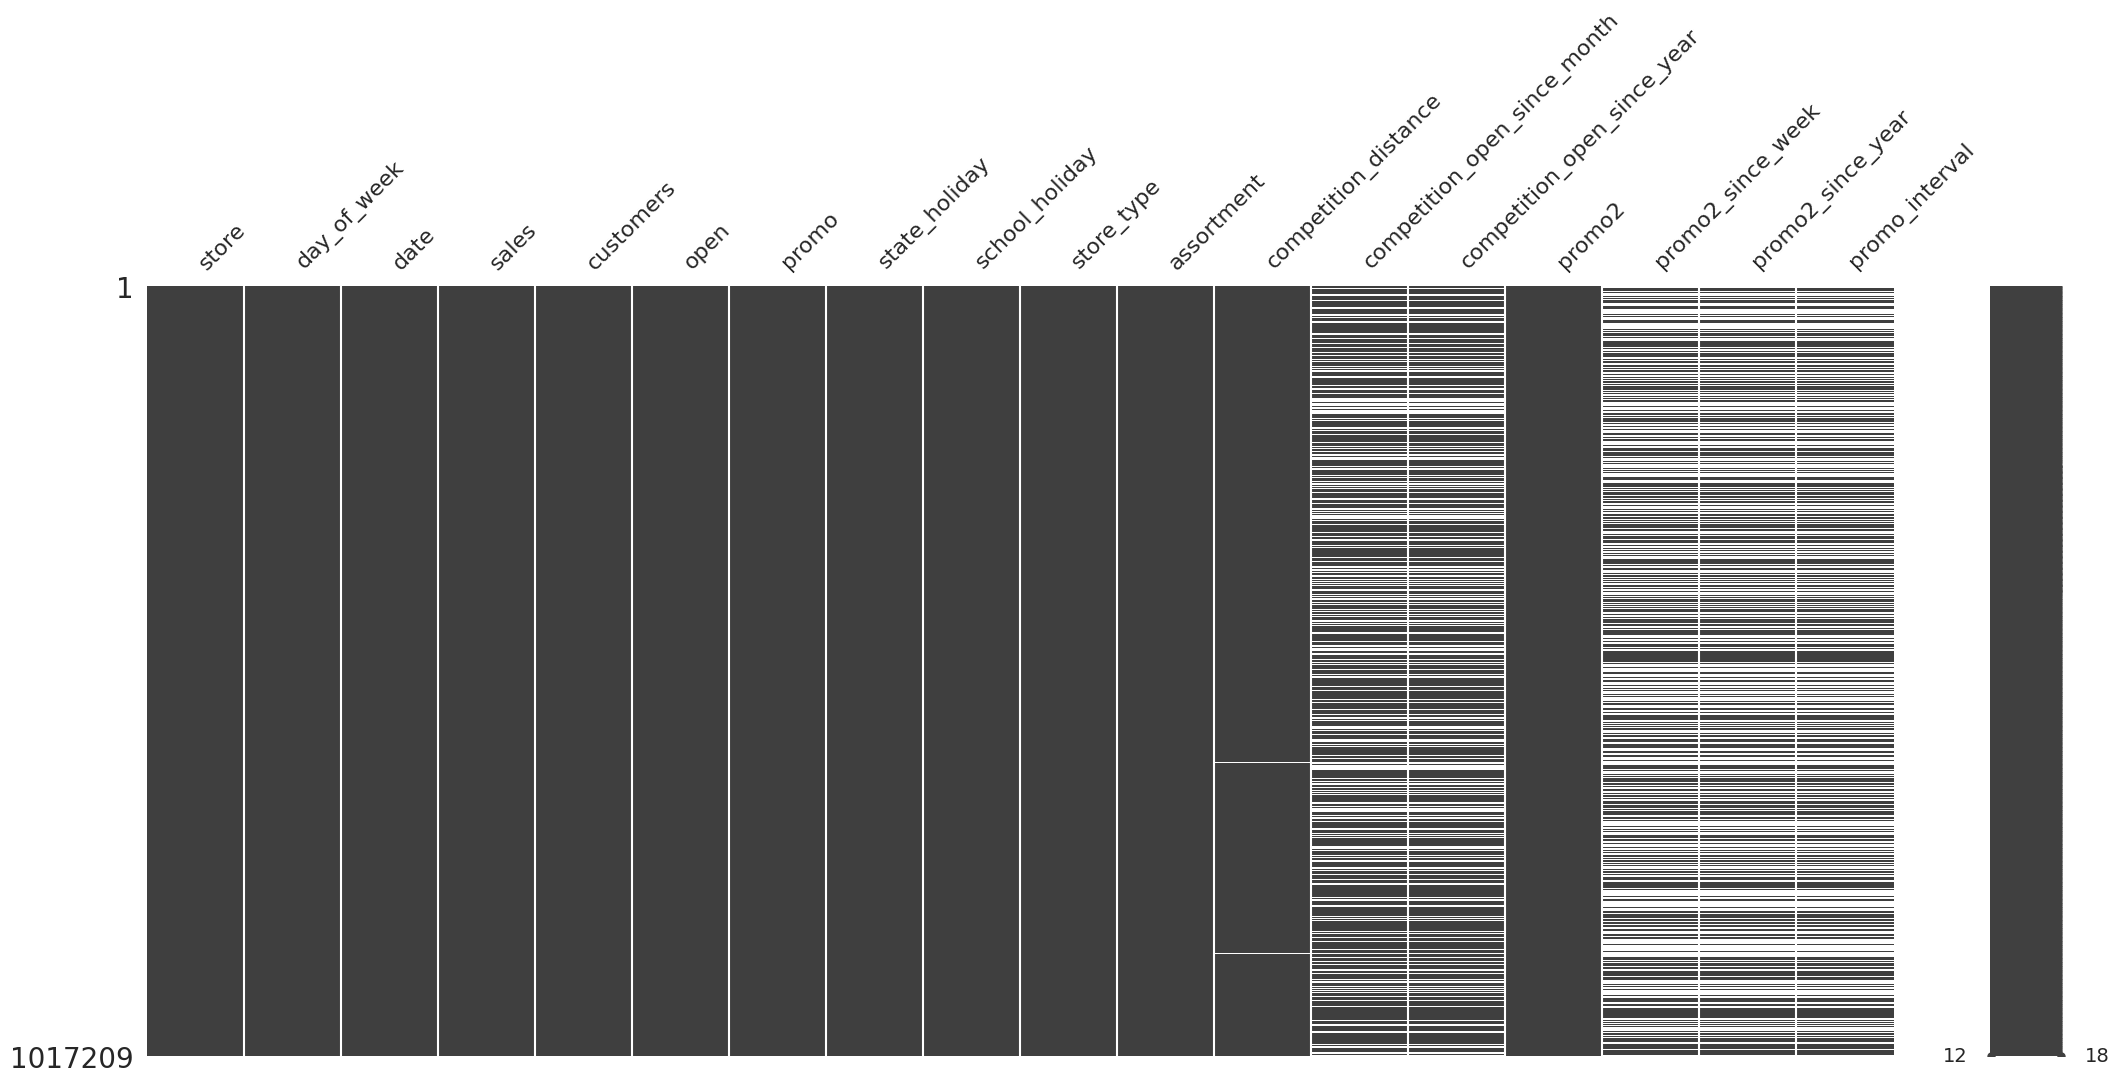

In [50]:
# Mostrar uma matriz de valores ausentes (NaN) no DataFrame df1 usando a função msno.matrix
msno.matrix(df1);

In [51]:
# Contar o número de valores ausentes (NaN) em cada coluna do DataFrame df1
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### Analyze all NA cases

**Casos de NA para serem tratados:**

| **Colunas**                      | **NA**    |
|----------------------------------|-----------|
| competition_distance             | 2642      |
| competition_open_since_month     | 323348    |
| competition_open_since_year      | 323348    |
| promo2_since_week                | 508031    |
| promo2_since_year                | 508031    |
| promo_interval                   | 508031    |


#### Caso 1 - Competition_distance: indica a distancia em metros do competidor mais próximo

In [52]:
""" 
Assumindo que no caso de valores ausente não há competidores próximos.
Vou vou atribuir pros NAs um valor bem maior que o maior valor de distância existente.
"""

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#### Caso 2 - competition_open_since_month: indica o mês aproximado da abertura do competidor mais próximo

In [53]:
"""
Se esta coluna está vazia, é porque pode não haver competidor próximo ou pode ser devido à falta de informação sobre a data de abertura.
Vou assumir que a data de venda (date) é a mesma que a data de abertura do competidor.
"""

df1['competition_open_since_month'] = df1.apply(lambda x: x.date.month if math.isnan(x.competition_open_since_month) else x.competition_open_since_month, axis=1)


#### Caso 3 - competition_open_since_year: indica ano aproximado da abertura do competidor mais próximo

In [54]:
# Vou assumir para years a mesama solução realizada em month
df1['competition_open_since_year'] = df1.apply(lambda x: x.date.year if math.isnan(x.competition_open_since_year) else x.competition_open_since_year, axis=1)

#### Caso 4 - promo2_since_week: indica a semana do calendário em que a loja começou a participar do Promo2

In [55]:
"""
Descreve a semana do calendário em que a loja começou a participar do Promo2
Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando

vou manter a mesma estratégia, utilizando a data de venda como referência para definir esses valores.
"""

df1['promo2_since_week'] = df1.apply(lambda x: x.date.week if math.isnan(x.promo2_since_week) else x.promo2_since_week, axis=1)

#### Caso 5 - promo2_since_year: indica o ano do calendário em que a loja começou a participar do Promo2

In [56]:
"""
Descreve o ano do calendário em que a loja começou a participar do Promo2
Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando

vou manter a mesma estratégia, utilizando a data de venda como referência para definir esses valores.
"""

df1['promo2_since_year'] = df1.apply(lambda x: x.date.year if math.isnan(x.promo2_since_year) else x.promo2_since_year, axis=1)

#### Caso 6 - promo_interval: indica o intervalo de tempo entre as promoções

In [57]:
"""
Para resolver a questão dos valores NA neste caso, 
optei em preenchê-los com zeros como uma medida para garantir a integridade dos dados 
e simplificar as etapas de análise subsequentes.
"""

# month_map é um dicionário que mapeia números de mês para abreviações de meses.
month_map = {1: 'jan', 
             2: 'Feb', 
             3: 'Mar', 
             4: 'Apr', 
             5: 'May',
             6: 'Jun', 
             7: 'Jul', 
             8: 'Aug', 
             9: 'Sept', 
             10:'Oct', 
             11:'Nov', 
             12:'Dec'}

# Preenche os valores ausentes na coluna 'promo_interval' com 0 e modifica o DataFrame inplace.
df1['promo_interval'].fillna(0, inplace=True);

# Cria uma nova coluna 'month_map' que mapeia os meses baseado na coluna 'date'.
df1['month_map'] = df1['date'].dt.month.map(month_map);

# Cria uma nova coluna 'is_promo' para indicar se uma promoção está ocorrendo no mês correspondente.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1);


### Result

In [58]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### Change Types

In [59]:
# Após as alterações realizadas nas colunas, é essencial verificar se o formato dos dados permaneceu o mesmo.
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [60]:
# converter de float pra int64

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [61]:
# Conferindo
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## Descriptive Statistical

In [62]:
#Separação de Variáveis Numéricas e Categóricas para Aplicação da analise descritiva:
num_attributes = df1.select_dtypes ( include=['int64','float64'] )
cat_attributes = df1.select_dtypes ( exclude=['int64','float64','datetime64[ns]'] )

### Numerical Attribures

In [63]:
#Central Tendency - mean - median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - STD, min, max, range, sken, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#Concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


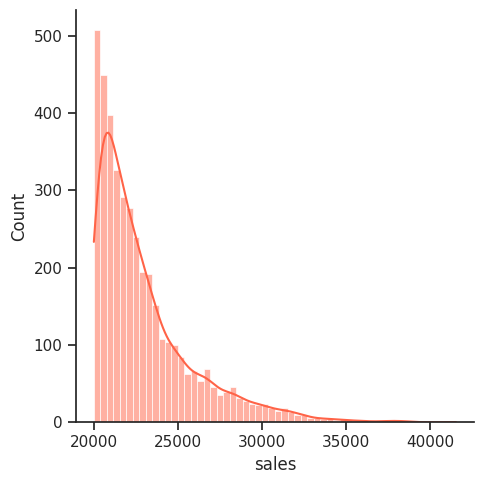

In [81]:
# Criar uma máscara booleana para identificar valores de 'sales' maiores que 20000
aux = df1['sales'] > 20000

# Aplicar a máscara para selecionar os dados filtrados da coluna 'sales'
dados_filt = df1.loc[aux, 'sales']

# Plotar o histograma com KDE para os dados filtrados
sns.displot(dados_filt, kde=True, color='#FF6347');

### Categorical Attibures

In [65]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

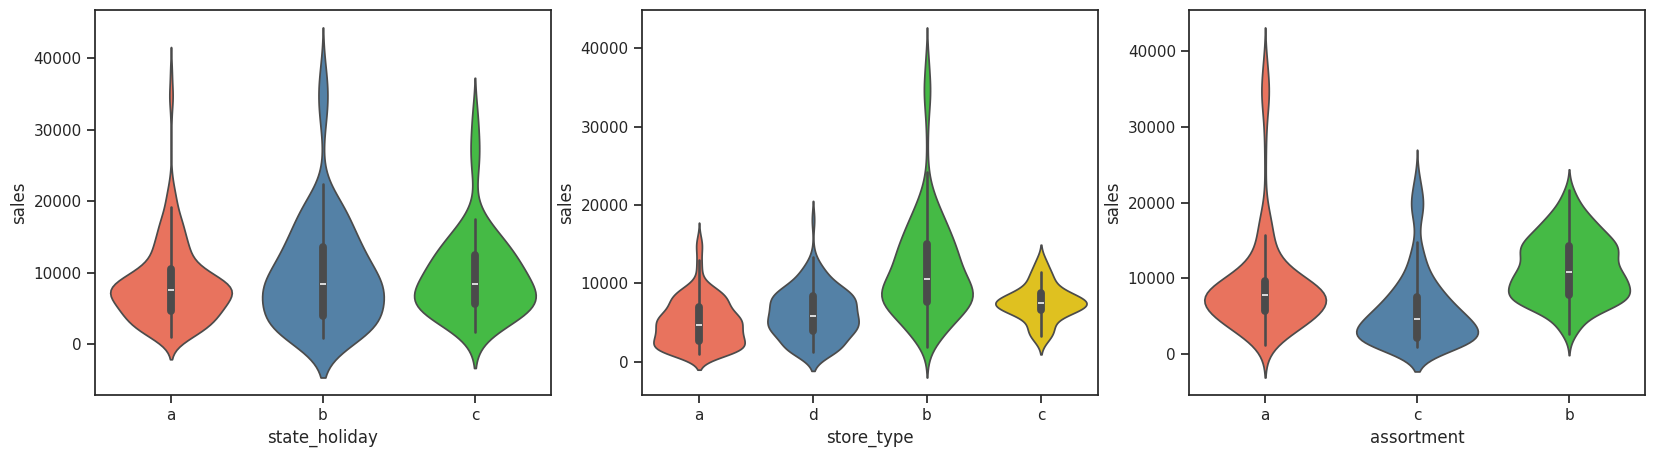

In [75]:
# Paleta de cores personalizada
cores = ["#FF6347", "#4682B4", "#32CD32", "#FFD700"]

#Atualizei o cálculo para desconsiderar os dias sem vendas
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)] 

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.violinplot(x='state_holiday', y='sales', data=aux1, palette=cores)

plt.subplot(1, 3, 2)
sns.violinplot(x='store_type', y='sales', data=aux1, palette=cores)

plt.subplot(1, 3, 3)
sns.violinplot(x='assortment', y='sales', data=aux1, palette=cores);

#### `Análise do violinplot 1: quantidade de vendas por tipo de feriado:`

Legenda de state_holiday:
- a = feriado público
- b = feriado de Páscoa
- c = Natal

A mediana de vendas nos feriados de Páscoa (b) e Natal (c) é mais alta do que nos feriados públicos (a).

A mediana de vendas nos feriados de Páscoa (b) e Natal (c) é semelhante, porém a dispersão é maior durante a Páscoa.

#### `Análise do violinplot 2: quantidade de vendas por tipo de loja:`

Legenda de StoreType:
- a
- d
- b
- c

A loja do tipo b vende aproximadamente o dobro da mediana em comparação com as outras, especialmente a do tipo a.

A concentração de vendas ao redor da mediana é maior para a loja do tipo c.

#### `Análise do violinplot 3: quantidade de vendas por mix de produtos:`

Legenda de Assortment:
- a = básico
- b = extra
- c = estendido

O mix de produtos extra (b) tem significativamente mais vendas do que os outros. Além disso, a variabilidade nas vendas é maior para esse mix.

O mix básico (a) possui muitos outliers, mas a distribuição das vendas fora desses outliers é bastante uniforme.

In [74]:
#contar a quantidade de valores únicos em cada coluna que contém atributos categóricos
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64